<a href="https://colab.research.google.com/github/Alex-Bernal27/Colab/blob/main/PIA_Reconocimiento_de_Emociones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RECONOCIMIENTO DE EMOCIONES
---



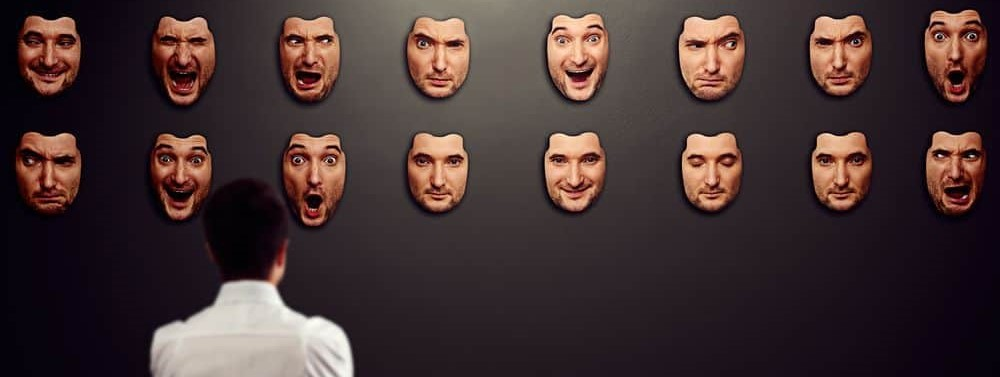

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix

from keras.models import Sequential
from keras.regularizers import l2
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, BatchNormalization
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

## PREPARAR DATOS

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Descargar los datos desde Google Drive
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PIA/icml_face_data.csv')
data.columns = ['emotion', 'Usage', 'pixels']
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [ ]:
#Funcion para darle forma a los datos (28709, 48, 48, 1) y tomar los pixeles
def prepare_data(data):
    image_array = np.empty(shape=(len(data), 48, 48, 1))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        #Tomar los datos del csv para convertirlos a numero float y despues a una matriz de 48x48
        image = np.fromstring(data.loc[row, 'pixels'], dtype=float, sep=' ').reshape(48, 48)
        image_array[i, :, :, 0] = image / 255

    return image_array, image_label

#Funcion para crear las graficas
def graph(h1):
    epoch_range = range(1, len(h1.epoch)+1)

    plt.figure(figsize=[12,6])
    plt.subplot(1,2,1)
    plt.plot(epoch_range,h1.history['loss'])
    plt.plot(epoch_range, h1.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training Loss', 'Validation Loss'])

    plt.subplot(1,2,2)
    plt.plot(epoch_range, h1.history['accuracy'])
    plt.plot(epoch_range, h1.history['val_accuracy'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training Accuracy', 'Validation Accuracy'])
    plt.show()

In [ ]:
#Dado los datos de training y test darles forma
full_train_images, full_train_labels = prepare_data(data[data['Usage']=='Training'])
test_images, test_labels = prepare_data(data[data['Usage']!='Training'])

print(full_train_images.shape)
print(full_train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(28709, 48, 48, 1)
(28709,)
(7178, 48, 48, 1)
(7178,)


In [ ]:
#Utilizar 80% de las imagenes para entrenamiento y 20% para test
train_images, valid_images, train_labels, valid_labels = train_test_split(full_train_images, full_train_labels, test_size=0.2, random_state=1)

print(train_images.shape)
print(train_labels.shape)
print(valid_images.shape)
print(valid_labels.shape)

(22967, 48, 48, 1)
(22967,)
(5742, 48, 48, 1)
(5742,)


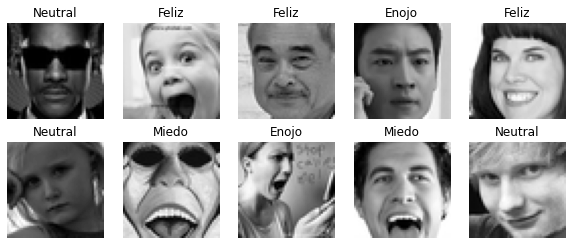

In [ ]:
# Mostrar algunas imagenes del dataset
emotions = {0: 'Enojo', 1: 'Disgusto', 2: 'Miedo', 3: 'Feliz', 4: 'Triste', 5: 'Sorpresa', 6: 'Neutral'}
N_train = train_labels.shape[0]

sel = np.random.choice(range(N_train), replace=False, size=16)

X_sel = train_images[sel, :, :, :]
y_sel = train_labels[sel]

plt.figure(figsize=[10,4])
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X_sel[i,:,:,0], cmap='binary_r')
    plt.title(emotions[y_sel[i]])
    plt.axis('off')
plt.show()

## MODELO

In [ ]:
cnn = Sequential()

cnn.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1), kernel_regularizer=l2(0.01)))
cnn.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn.add(Dropout(0.5))

cnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(BatchNormalization())
cnn.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn.add(Dropout(0.5))

cnn.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(BatchNormalization())
cnn.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn.add(Dropout(0.5))

cnn.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(BatchNormalization())
cnn.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
cnn.add(Dropout(0.5))

cnn.add(Flatten())

cnn.add(Dense(512, activation='relu'))
cnn.add(Dropout(0.4))
cnn.add(Dense(512, activation='relu'))
cnn.add(Dropout(0.4))
cnn.add(Dense(512, activation='relu'))
cnn.add(Dropout(0.5))

cnn.add(Dense(7, activation='softmax'))

cnn.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_43 (Batc (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 23, 23, 128)       73856     
_________________________________________________________________
batch_normalization_44 (Batc (None, 23, 23, 128)      

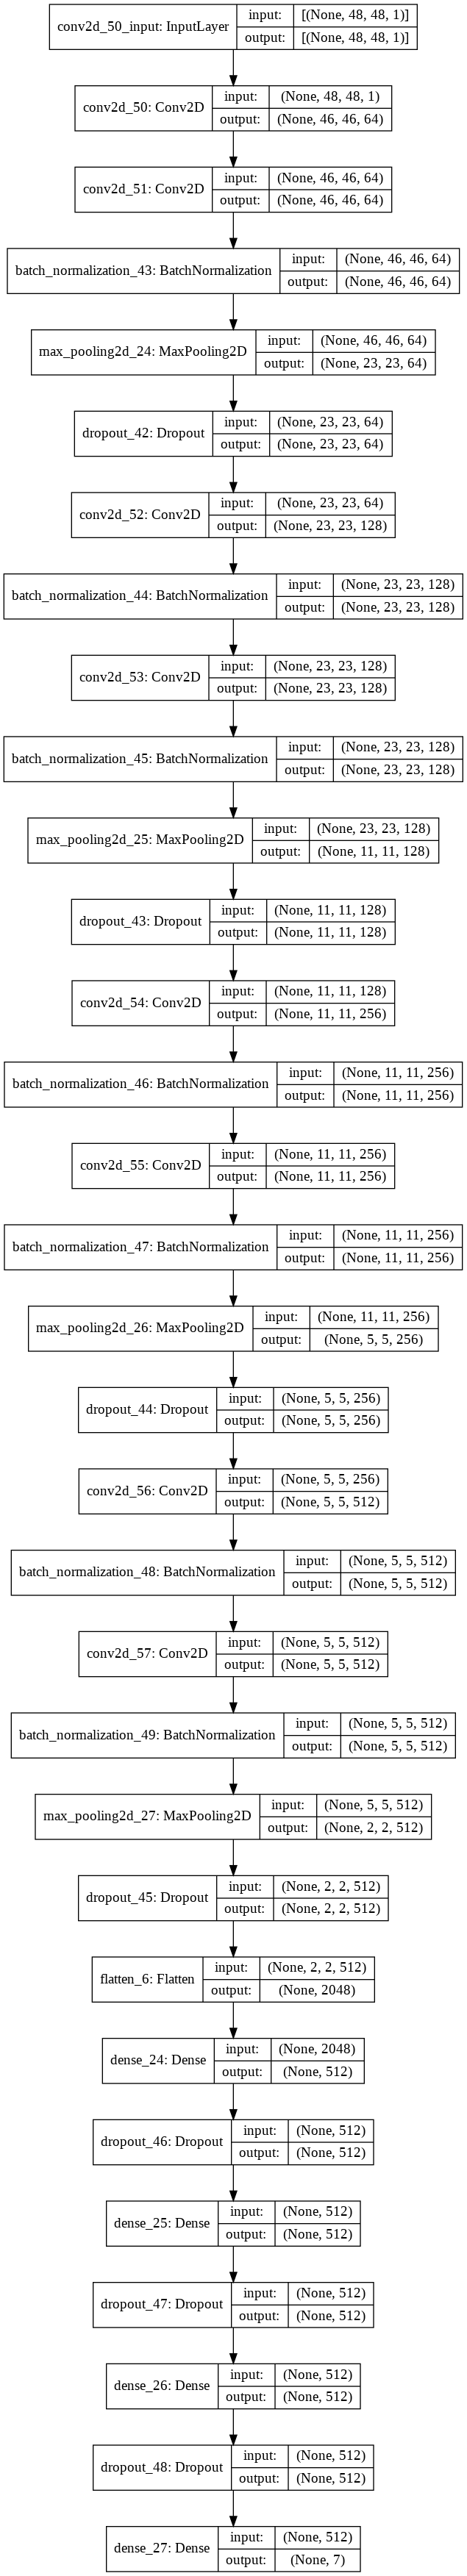

In [ ]:
tf.keras.utils.plot_model(cnn, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
cnn.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint
epochs=45
callback = [tf.keras.callbacks.ModelCheckpoint("model.weights.best.hdf5", monitor='val_accuracy', save_best_only=True, mode='max')]
h1 = cnn.fit(train_images,
         train_labels,
         batch_size=64,
         epochs=epochs,
         validation_data =(valid_images, valid_labels),
         callbacks=callback)

Epoch 1/45
359/359 [==============================] - 23s 61ms/step - loss: 2.2600 - accuracy: 0.2007 - val_loss: 1.8430 - val_accuracy: 0.2564
Epoch 2/45
359/359 [==============================] - 21s 60ms/step - loss: 1.8409 - accuracy: 0.2337 - val_loss: 1.8101 - val_accuracy: 0.2598
Epoch 3/45
359/359 [==============================] - 21s 60ms/step - loss: 1.8159 - accuracy: 0.2502 - val_loss: 1.9169 - val_accuracy: 0.2564
Epoch 4/45
359/359 [==============================] - 21s 59ms/step - loss: 1.7436 - accuracy: 0.2999 - val_loss: 1.7539 - val_accuracy: 0.2933
Epoch 5/45
359/359 [==============================] - 21s 60ms/step - loss: 1.6460 - accuracy: 0.3470 - val_loss: 1.6192 - val_accuracy: 0.3441
Epoch 6/45
359/359 [==============================] - 21s 59ms/step - loss: 1.5617 - accuracy: 0.3876 - val_loss: 1.5886 - val_accuracy: 0.3455
Epoch 7/45
359/359 [==============================] - 21s 59ms/step - loss: 1.4885 - accuracy: 0.4238 - val_loss: 1.3929 - val_accuracy:

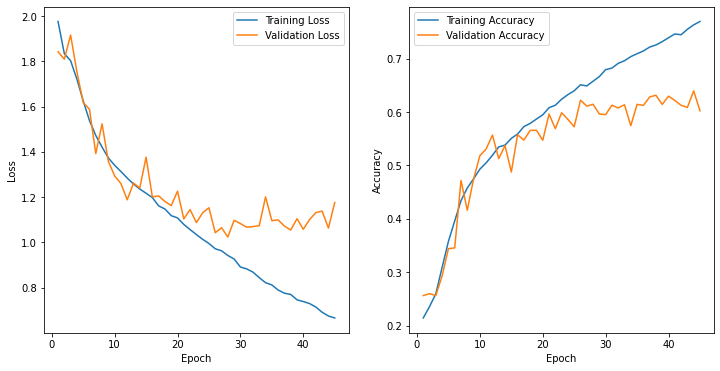

In [ ]:
graph(h1)

In [ ]:
cnn.save('/content/drive/MyDrive/Colab Notebooks/PIA/model.weights.best.hdf5')

In [ ]:
cnn = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/PIA/model.weights.best.hdf5')

## ACCURACY

In [ ]:
#Dado la prediccion obtener el accuracy dependiendo con los labels del test verdadero
test_prob = cnn.predict(test_images)
test_pred = np.argmax(test_prob, axis=1)
test_accuracy = np.mean(test_pred == test_labels)

print(test_accuracy)

0.6327667874059627


In [ ]:
#Crear la matriz de confusion con las predicciones y usarlas en un DataFrame
conf_mat = confusion_matrix(test_labels, test_pred)
pd.DataFrame(conf_mat, columns=emotions.values(), index=emotions.values())

,Enojo,Disgusto,Miedo,Feliz,Triste,Sorpresa,Neutral
Enojo,460,12,69,97,136,18,166
Disgusto,33,50,11,4,4,1,8
Miedo,88,7,331,70,231,102,195
Feliz,18,0,18,1544,42,28,124
Triste,100,4,88,96,633,22,304
Sorpresa,16,1,47,66,23,638,40
Neutral,45,3,31,91,163,14,886


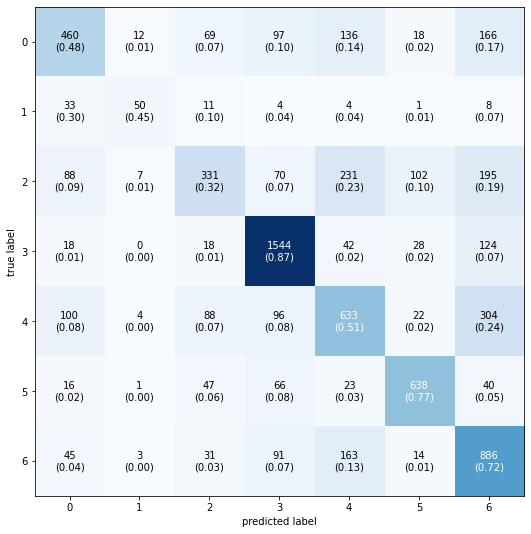

In [ ]:
#Crear la figura para la matriz de confusion
fig, ax = plot_confusion_matrix(conf_mat=conf_mat, show_normed=True, show_absolute=True, hide_ticks= False, figsize=(9, 9))
fig.show()

## PREDICCIONES

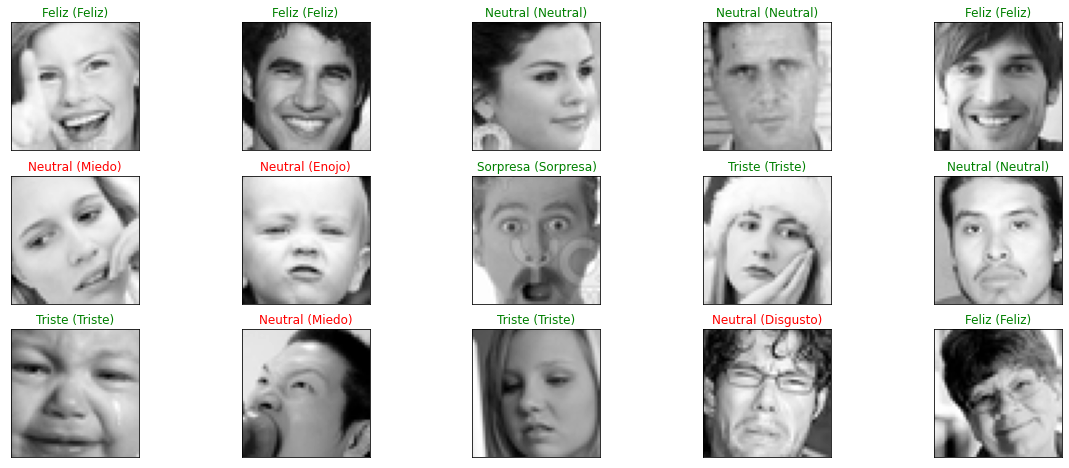

In [ ]:
test_prob = cnn.predict(test_images)

# imágenes de prueba, sus etiquetas predichas y la verdadera
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(test_images.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Mostrar cada imagen 
    ax.imshow(np.squeeze(test_images[index]),cmap=plt.get_cmap('gray'))
    predict_index = np.argmax(test_prob[index])
    true_index = test_labels[index]
    # Ponerle titulo a las imagenes
    ax.set_title("{} ({})".format(list(emotions.values())[predict_index], 
                                  list(emotions.values())[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

In [ ]:
def predict_class(filename, model):
  img = load_img(filename,target_size=( 48 , 48, 3)) # Lectura como imagen a color
  plt.imshow(img,cmap='Greys')
  img = img_to_array(img) 
  img = np.mean(img, axis=2)
  img = img.reshape(1,48,48,1)
  img = img.astype('float32')
  img = img/255.0
  result = model.predict(img)
  dict2 = {}
  for i in range(7):
    dict2[result[0][i]] = emotions.get(i)
  res = result[0]
  res.sort()
  res = res[::-1]
  results = res[:3]
  print("Top predictions of these images are")
  for i in range(3):
    print("{} : {}".format(dict2[results[i]],
                           (results[i]*100).round(2)))
  print('The image given as input is')

Top predictions of these images are
Feliz : 99.62
Miedo : 0.2
Enojo : 0.1
The image given as input is


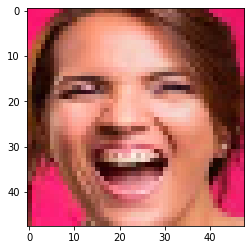

In [ ]:
predict_class('/content/drive/MyDrive/Colab Notebooks/PIA/Feliz.PNG',cnn)